# Week 3 - Ungraded Lab: Data Labeling

Welcome to the ungraded lab for week 3 of Machine Learning Engineering for Production. In this lab, you will see how the data labeling process affects the performance of classification models. Labeling data is usually a very labor intensive and costly task.  One appealing option to overcome these problems is to automate the labeling process. [Snorkel](https://www.snorkel.org/) is a popular library to perform automatic data labelling. The main objective of this ungraded lab is to compare performance across three labeling options:
1. Randomly generated labels (performance lower bound)
2. Snorkel generated labels 
3. True labels (performance upper bound)

In this ungraded lab, you will be using a dataset containing comments from the 2015 top 5 most popular Youtube videos. Each comment has been labeled as `spam` or `not_spam` depending on its contents.

As a final remark, this lab takes inspiration from [this tutorial](https://www.snorkel.org/use-cases/01-spam-tutorial), which is part of Snorkel's official tutorial list. We recommend to check it out to have a broader view on Snorkel's functionalities and capabilities not covered in this lab.

 

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the dataset

The dataset consists of 5 CSV files, one for each video. Pandas `DataFrame` are very powerful to handle data in CSV format. The following helper function will load the data using pandas:

In [2]:
def load_labeled_spam_dataset():
    """Load labeled spam dataset."""
    filenames = sorted(glob.glob("data/Youtube*.csv"))
    dfs = []
    for i, filename in enumerate(filenames, start=1):
        df = pd.read_csv(filename)
        df.columns = map(str.lower, df.columns)
        df["video"] = [i] * len(df)
        df = df.rename(columns={"class": "label", "content": "text"})
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        dfs.append(df)
    
    return pd.concat(dfs).reset_index()

# Save the dataframe into the df_labeled variable
df_labeled = load_labeled_spam_dataset()

To have a feeling of how the data is organized, let's inspect the top 5 rows of the data:

In [3]:
# Take a look at the first 5 rows
df_labeled.head()

,index,comment_id,author,date,text,label,video
0,0,z13ky1cgzpjpvdpp004chhebvqnkhnpjmzo0k,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,1,1
1,1,z12tcdxa5k3bsvtqh04ccnaqusj1vvfju3s,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",1,1
2,2,z12stpyqaonsercxw04cjbr4dlnrxd34soo0k,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,0,1
3,3,z13autsqgzblcx3w104chr4r2kexd10rxc0,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",0,1
4,4,z13qgpqwlqbgj5jqy04cgnjqruv0gpdaino0k,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",0,1


## Further inspection and preprocessing


### Checking for data imbalance

It is fairly common to assume that the data you are working on is balanced. This means that the dataset contains a similar proportion of examples for all classes. Before moving forward let's actually test this assumption:

Value counts for each class:

1    1005
0     951
Name: label, dtype: int64



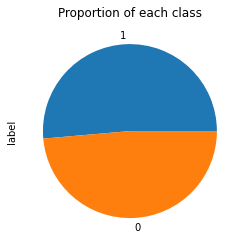

In [4]:
# Print actual value count
print(f"Value counts for each class:\n\n{df_labeled.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df_labeled.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

There is roughly the same number of data points for each class so class imbalance is not an issue for this particular dataset.


### Cleaning the dataset

If you scroll back to the cell where  you inspected the data, you will realize that the dataframe includes information that is not relevant for the task at hand. At the moment, you are only interested in the comments and the corresponding labels (the video that each comment belongs to will be used later). Let's drop the remaining columns.

In [5]:
# Drop unused columns
df_labeled = df_labeled.drop(['index', 'comment_id', 'author', 'date'], axis=1)

# Look at the cleaned dataset
df_labeled.head()

,text,label,video
0,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,1,1
1,"if your like drones, plz subscribe to Kamal Ta...",1,1
2,go here to check the views :3﻿,0,1
3,"Came here to check the views, goodbye.﻿",0,1
4,"i am 2,126,492,636 viewer :D﻿",0,1


Now the dataset only includes the information you are going to use moving forward.

### Splitting the dataset

Before jumping to the data labeling section let's split the data into training and test sets so you can use the latter to measure the performance of models that were trained using data labeled through different methods. As a safety measure when doing this split, remember to use stratification so the proportion of classes is maintained within each split.

In [6]:
from sklearn.model_selection import train_test_split

# Save the text into the X variable
X = df_labeled.drop("label", axis=1)

# Save the true labels into the y variable
y = df_labeled["label"]

# Use 1/5 of the data for testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print number of comments for each set
print(f"There are {X_train.shape[0]} comments for training.")
print(f"There are {X_test.shape[0]} comments for testing")

There are 1564 comments for training.
There are 392 comments for testing


Let's do a visual to check that the stratification actually worked:

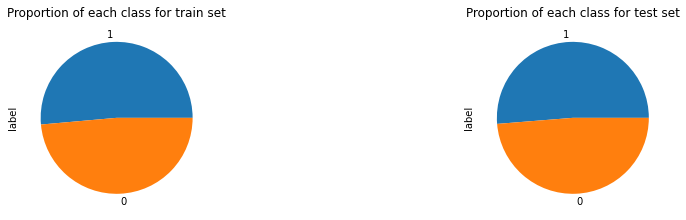

In [7]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

Both, the training and test sets a balanced proportion of examples per class. So, the code successfully implemented stratification.  

Let's get going!

## Data Labeling

### Establishing a baseline with random sampling

To properly compare different labeling strategies you need to establish a baseline for model accuracy. Generating random  labels is a natural way to establish such baseline. You will expect that any successful alternative labeling model to outperform randomly generated labels. Let's go over the process of implementing a baseline. 

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) is a handy tool included in the sklearn ecosystem to encode text based data.

For more information on how to work with text data using sklearn check out this [resource](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Allow unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 5))

Now that the text encoding is defined, you need to select a model to make predictions. For simplicity you will use a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier. This model is well suited for text classification and is fairly quick to train.

Let's define a function which will handle the model fitting and print out the accuracy on the test data:

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


def calculate_accuracy(X_tr, y_tr, X_te=X_test, y_te=y_test, 
                       clf=MultinomialNB(), vectorizer=vectorizer):
    
    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_tr.text.tolist())
    
    # Fit model
    clf.fit(X=X_train_vect, y=y_tr)
    
    # Vectorize test text
    X_test_vect = vectorizer.transform(X_te.text.tolist())
    
    # Make predictions for the test set
    preds = clf.predict(X_test_vect)
    
    # Return accuracy score
    return accuracy_score(preds, y_te)


Now let's create a dictionary  to store the accuracy of each labeling method:

In [10]:
# Empty dictionary
accs = dict()

### Random Labeling

Now let's calculate the accuracy for the random labeling method

In [11]:
# Calculate random labels
rnd_labels = np.random.randint(0, 2, X_train.shape[0])

# Feed them alongside X_train to calculate_accuracy function
rnd_acc = calculate_accuracy(X_train, rnd_labels)

rnd_acc

0.5331632653061225

You will see a different accuracy everytime you run the previous cell. This is due to the fact that the labeling is done randomly. Remember, this is a binary classification problem and both classes are balanced, so you can expect to see accuracies that revolve around 50%.

To further gain intuition let's look at the average accuracy over 10 runs:

In [12]:
# Empty list to save accuracies
rnd_accs = []

for _ in range(10):
    # Add every accuracy to the list
    rnd_accs.append(calculate_accuracy(X_train, np.random.randint(0, 2, X_train.shape[0])))

# Save result in accs dictionary
accs['random-labels'] = sum(rnd_accs)/len(rnd_accs)

# Print result
print(f"The random labelling method achieved and accuracy of {accs['random-labels']*100:.2f}%")

The random labelling method achieved and accuracy of 47.04%


Random labelling is completely disregarding the information from the solution space you are working on, and is just guessing the correct label. You can't probably do worse than this (or maybe you can). For this reason, this method serves as a baseline for comparing other labeling methods


### Labeling with true values

Now let's look at the other end of the spectrum, this is using the correct labels for your data points. Let's retrain the Multinomial Naive Bayes classifier with the actual labels 

In [13]:
# Calculate accuracy when using the true labels
true_acc = calculate_accuracy(X_train, y_train)

# Save the result
accs['true-labels'] = true_acc

print(f"The true labelling method achieved and accuracy of {accs['true-labels']*100:.2f}%")

The true labelling method achieved and accuracy of 89.03%


Training with the true labels produced a noticeable boost in accuracy. This is expected as the classifier is now able to properly identify patterns in the training data which were lacking with randomly generated labels. 

Notice that the accuracy is not at >99%. Achieving higher accuracy is possible by either fine-tunning the model or even selecting different one. For the time being you will keep the model as it is and use this accuracy as what we should strive for with the automatic labeling algorithms you will see next.

## Enter Snorkel

Snorkel is a flexible library that provides functionality for developing end to end machine learning pipelines. It is most commonly known for it's utilities to clean and label datasets by combining heuristics with weak supervision approaches. You will see different attempts at defining automatic labelling rules using Snorkel and compare those against the previously established baselines.

First things first. Let's define some handy global variables:
- `SPAM` is represented by 1


- `NOT_SPAM` by 0 


- `ABSTAIN` (or no label) as -1


You might be wondering about the `ABSTAIN` keyword. Depending on the rules you come up with Snorkel might be unable to perform the automatic labeling. In such cases it should let you know this is the case so you can decide on how to proceed with these cases.

In [14]:
ABSTAIN = -1
NOT_SPAM = 0
SPAM = 1

### First iteration

There are many ways to define labeling rules in Snorkel. One of the more straightforward ones is by using `labeling functions`. One example of such function is: "if the comment contains the word 'free' classify it as SPAM".

To use this functionality you can create simple functions that return one of the tags depending on a rule and decorate them using snorkel's [`labeling_function`](https://snorkel.readthedocs.io/en/v0.9.3/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html) decorator.

For this first iteration you will create three  labeling functions based on the intuition of common patterns that appear on SPAM comments. The rules are simple, classify as SPAM if any of the following patterns is present within the comment or ABSTAIN otherwise:
- `free` - spam comments usually lure users by promoting free stuff
- `check out` - spam comments tend to ask users to check out some website or channel
- `http` - spam comments include links very frequently

In [15]:
from snorkel.labeling import labeling_function

@labeling_function()
def lf_keyword_free(x):
    return SPAM if "free" in x.text.lower() else ABSTAIN


@labeling_function()
def lf_regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN


@labeling_function()
def lf_contains_link(x):
    return SPAM if "http" in x.text.lower() else ABSTAIN

Now that the labeling rules have been defined, these can be applied to the data by using a [`PandasLFApplier`](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html) object. Snorkel provides several ways of applying rules to data in different formats. Since the data is in a dataframe, this is the best way to perform this.

The steps  needed for this process are:
1. create a list containing all of the labeling functions.  
2. create an instance of the `PandasLFApplier` class and pass the list of functions to it. 
3. use the applier to apply the rules to the dataframe.

The applier will return a numpy array called the **label matrix** which has a row for each data point and a column for each rule. Every entry of this matrix corresponds to the label that snorkel will give to that data point given that rule. 

In this case there are 1564 data points in the training set and you have just defined 3 rules so the resulting label matrix should have shape (1564, 3).

In [16]:
from snorkel.labeling import PandasLFApplier


# Create list of labeling functions
lfs = [lf_keyword_free, lf_regex_check_out, lf_contains_link]

# Define the apply_rules function to use it later
def apply_rules(df, lfs):
    applier = PandasLFApplier(lfs=lfs)
    L_train = applier.apply(df=df)
    return L_train


# Compute label matrix
L_train = apply_rules(X_train, lfs)

100%|██████████| 1564/1564 [00:00<00:00, 18177.34it/s]


Snorkel  provides another cool object, [`LFAnalysis`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html), which computes some descriptive statistics on the labeling functions using the label matrix.

In [17]:
from snorkel.labeling import LFAnalysis

# Print label matrix
print(f"Label matrix looks like this:\n\n{L_train}\n")

# Print shape of label matrix
print(f"and has shape {L_train.shape}\n")

# Output useful statistics
print("Labeling functions analysis:\n")
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

Label matrix looks like this:

[[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 ...
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]

and has shape (1564, 3)

Labeling functions analysis:



,j,Polarity,Coverage,Overlaps,Conflicts
lf_keyword_free,0,[1],0.023657,0.013427,0.0
lf_regex_check_out,1,[1],0.221867,0.012788,0.0
lf_contains_link,2,[1],0.102302,0.016624,0.0


The 3 rules you defined produced no conflicts so far. However, when you increase the number of labeling functions it is a common scenario for them to conflict when deciding on the appropiate label for a data point. In general, snorkel is aware that labeling functions are not perfect. In fact it is aware that they are usually **noisy, innacurate and overlapping**.

With this in mind, snorkel provides the [`LabelModel`](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html) object, which will decide on the best label for each data point. Quoting from the official docs: 

"This class learns a model of the labeling functions’ conditional probabilities of outputting the true (unobserved) label Y, P(lf | Y), and uses this learned model to re-weight and combine their output labels."

If you are interesting on how this is done be sure to check [this tutorial](https://www.snorkel.org/use-cases/01-spam-tutorial), to have a better understading of this process. At a high level explanation just know that given a set of noisy labeling functions this object will find the best combination of these rules to output the most realistic set of labels.

This API is really similar to sklearn's, having the `fit` and `predict` methods. Let's put it to work:

In [18]:
from snorkel.labeling.model import LabelModel

# Define automatic_labeling function to use it latter on
def automatic_labeling(L_train):
    """Train the label model and compute the training labels"""
    # Create an instance of the LabelModel class
    label_model = LabelModel(cardinality=2, verbose=True)
    
    # Fit the model
    label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
    
    # Return the predictions
    return label_model.predict(L=L_train)

With this setup the automatic_labeling function is ready to perform automatic labeling on the training data. This step uses the rules you previously defined.

In [19]:
# Compute predicted labels
preds = automatic_labeling(L_train)

# Shape of predicted labels
print(f"predictions have shape: {preds.shape}")

# Take a look at predicted labels
preds

predictions have shape: (1564,)


array([-1, -1, -1, ..., -1, -1, -1])

For lots of points the labeling algorithm decided to abstain which was already hinted at by the low coverage showed by the `LFAnalysis`. These points should be deleted since they don't provide information about the classification process and tend to hurt performance.

In [20]:
# Create the automatic labeled version of X_train by removing points with ABSTAIN label
X_train_al = X_train[preds != ABSTAIN]

# Remove predictions with ABSTAIN label
preds_al = preds[preds != ABSTAIN]

print(f"Predictions with concrete label have shape: {preds_al.shape}")

print(f"Proportion of data points kept: {preds_al.shape[0]/preds.shape[0]*100:.2f}%")

Predictions with concrete label have shape: (510,)
Proportion of data points kept: 32.61%


Notice that only 510 data points remained  out of the original 1564. The rules defined didn't provide enough context for snorkel to settle on a label, so around 2/3 of the data has been trimmed.

Let's test the accuracy of the model when using these automatic generated labels:

In [21]:
# Compute accuracy when using these labels
snorkl_1_acc = calculate_accuracy(X_train_al, preds_al)

# Display accuracy
print(f"First iteration of automatic labeling has an accuracy of {snorkl_1_acc*100:.2f}%")

# Save the result
accs['snorkel-first-iteration'] = snorkl_1_acc

First iteration of automatic labeling has an accuracy of 47.45%


Let's compare this accuracy to the baselines by plotting:

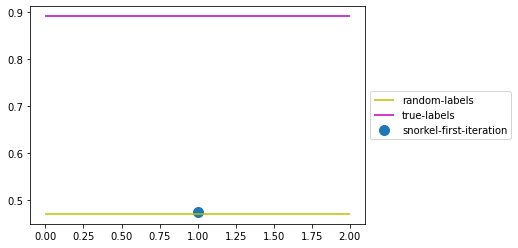

In [22]:
def plot_accuracies(accs=accs):
    colors = list("rgbcmy")
    items_num = len(accs)
    cont = 1

    for x, y in accs.items():
        if x in ['true-labels', 'random-labels', 'true-labels-best-clf']:
            plt.hlines(y, 0, (items_num-2)*2, colors=colors.pop())
        else:
            plt.scatter(cont, y, s=100)
            cont+=2
    plt.legend(accs.keys(), loc="center left",bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_accuracies()

This first iteration had an accuracy even worse than the random labeling baseline model. This is probably because we are using only 1/3 of the available data. Going forward we should come up with rules that have a better coverage of the training data, and thus making pattern discovery an easier task. This should help snorkel perform the automatic labeling more accurately.

Before moving forward let's define the `label_given_rules` function that performs all of the steps you just saw, these are: 
- Computing the label matrix given the data and a set of rules
- Use LabelModel to get the predicted labels for each data point
- Delete all data points for which snorkel was unable to settle on a label
- Calculate the accuracy of the model using the automatic labels
- Save the accuracy for plotting

In [23]:
def label_given_rules(df, lfs, clf, name, X_te=X_test, y_te=y_test, accs_dict=accs, verbose=True):
    # Compute label matrix
    L_train = apply_rules(df, lfs)
    
    # Perform automatic labeling
    preds = automatic_labeling(L_train)
    
    # Save initial number of data points
    initial_size = preds.shape[0]
    
    # Trim points with ABSTAIN label
    X_train_al = df[preds != ABSTAIN]
    preds = preds[preds != ABSTAIN]
    
    # Save number of data points after trimming
    final_size = preds.shape[0]
    
    # Compute accuracy
    acc = calculate_accuracy(X_train_al, preds, clf=clf, X_te=X_te, y_te=y_te)
    
    # Print useful information
    if verbose:
        print(f"Proportion of data points kept: {final_size/initial_size*100:.2f}%\n")
        print(f"{name} labeling has an accuracy of {acc*100:.2f}%\n")
        
    # Save accuracy to accuracies dictionary
    accs_dict[name] = acc
    
    return X_train_al, preds, acc

A natural follow up question is how can you come up with better labeling rules.

For instance, note that the rules previously defined only output SPAM or ABSTAIN, so they didn't include any patterns for classifying NOT_SPAM. Perhaps adding rules for NOT_SPAM might help.

### Second iteration - Coming up with better rules

In the previous section we explicitly coded all of the labeling function even if they had a very similar structure.

Now you are going to define a general function `keyword_lookup`, which has a common structure regardless of the word or label. This function can be wrapped using the [`LabelingFunction`](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html) object and this can be returned by the `make_keyword_lf` to create a sort of closure. 

This is very similar to what happens when using the `@labeling_function` decorator. If you are familiar with closures this should be easy to understand, if not, it is sufficient to know that you are achieving the same result via this method or by using the decorator. In this sense every `make_keyword_lf` will be a labeling function.

In [24]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(re.search(word, x.text.lower(), flags=re.I) for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

keyword_my = make_keyword_lf(keywords=["my"])
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])
keyword_link = make_keyword_lf(keywords=["http"])
keyword_please = make_keyword_lf(keywords=["please", "plz"])
keyword_song = make_keyword_lf(keywords=["song"], label=NOT_SPAM)

By default the function classifies examples as SPAM but this can be changed by using the optional parameter `label`. In this case we have included a rule for classifying as NOT_SPAM when the keyword "song" is present in the comment.

The other rules are very similar to the first iteration: classify as SPAM if the keywords "my", "subscribe", "http", "please" or "plz" appear in the comments as these are very common among SPAM comments.

Let's run the rules over the training data, retrieve the label matrix and print out useful statistics:

In [25]:
# Create list of labeling functions
lfs = [keyword_my, lf_regex_check_out, keyword_link, keyword_subscribe, keyword_please, keyword_song]

# Compute label matrix
L_train = apply_rules(X_train, lfs)

100%|██████████| 1564/1564 [00:00<00:00, 7484.50it/s]


In [26]:
# Output useful statistics
print("Labeling functions analysis:\n")
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

Labeling functions analysis:



,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.192455,0.168159,0.034527
lf_regex_check_out,1,[1],0.221867,0.098465,0.020460
keyword_http,2,[1],0.102302,0.036445,0.006394
keyword_subscribe,3,[1],0.126598,0.083120,0.008312
keyword_please,4,[1],0.108056,0.096547,0.012148
keyword_song,5,[0],0.159207,0.049872,0.049872


This new set of rules makes a better job at covering the training dataset. This should result in snorkel abstaining less than in the first iteration.

Let's check if this is the case.

100%|██████████| 1564/1564 [00:00<00:00, 7506.52it/s]


Proportion of data points kept: 59.27%

snorkel-second-iteration labeling has an accuracy of 60.71%



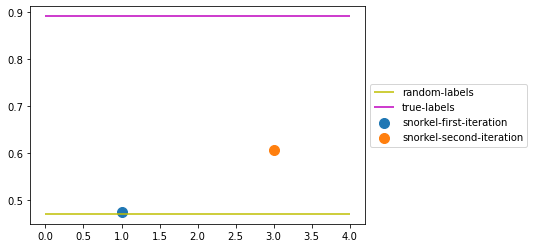

In [27]:
label_given_rules(X_train, lfs, MultinomialNB(), "snorkel-second-iteration")

plot_accuracies()

This time 61% of the original dataset was given a decisive label which helped the model reach a higher accuracy when compared to the first iteration. Now the accuracy is considerably higher than the random labeling but it is still very far away from the upper bound.

Let's see if we can make it even better!

### Third Iteration - Even more rules

The rules we have defined so far are doing a fair job. Let's add two additional rules that focus on detecting NOT_SPAM comments since most of the existing rules focus on the opposite task.

The first labeling function will use a third-party model for sentiment classification. The idea is that non-spam comments are commonly positive. The polarity metric used is a value between -1 and 1. In a similar fashion, many non-spam comments are short.

Let's define these two new rules:

In [28]:
from textblob import TextBlob

@labeling_function()
def lf_textblob_polarity(x):
    return NOT_SPAM if TextBlob(x.text).sentiment.polarity > 0.3 else ABSTAIN


@labeling_function()
def lf_short_comment(x):
    return NOT_SPAM if len(x.text.split()) < 5 else ABSTAIN

Next, append these two labeling functions to the previously defined list and apply it to the training data:

In [29]:
lfs.append(lf_textblob_polarity)
lfs.append(lf_short_comment)

# Compute label matrix
L_train = apply_rules(X_train, lfs)

100%|██████████| 1564/1564 [00:00<00:00, 2276.09it/s]


Now we can check coverage:

In [30]:
# Output useful statistics
print("Labeling functions analysis:\n")
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

Labeling functions analysis:



,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.192455,0.177110,0.086957
lf_regex_check_out,1,[1],0.221867,0.115090,0.059463
keyword_http,2,[1],0.102302,0.077366,0.057545
keyword_subscribe,3,[1],0.126598,0.101662,0.055627
keyword_please,4,[1],0.108056,0.100384,0.045396
keyword_song,5,[0],0.159207,0.122123,0.049872
lf_textblob_polarity,6,[0],0.292199,0.221228,0.109974
lf_short_comment,7,[0],0.258312,0.148338,0.063939


These new rules do a pretty well job at covering the dataset.

Let's train the model with these new labels and check performance:

100%|██████████| 1564/1564 [00:00<00:00, 2420.95it/s]


Proportion of data points kept: 82.16%

snorkel-third-iteration labeling has an accuracy of 74.49%



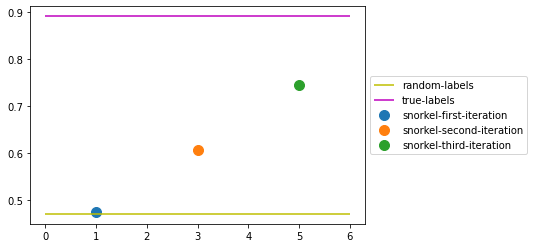

In [31]:
label_given_rules(X_train, lfs, MultinomialNB(),"snorkel-third-iteration")

plot_accuracies()

These labeling strategy reached an accuracy of ~75%! We are getting closer and closer to the upper bound defined by using the true labels.

We could keep going on adding more rules to improve accuracy and we do encourage you to try it out yourself!

However we are going to take another approach and that is to try out different classifiers. Maybe the labeling is already pretty good but another classifier might do a better job of generalizing.

Let's test this hypothesis!

### Selecting a classifier

The rules you implemented seem to be doing a fair job. Is it possible to do better with the same automatically generated labels? Perhaps changing the classifier will help in reaching a higher accuracy on the test data set. 
Let's leverage several sklearn classifiers to check if this is actually true:

In [32]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

clfs = [
    LogisticRegression(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier()
]

# Helper function to get a classifier's name
def clf_name(clf):
    return clf.__class__.__name__

Before doing this for the automatic labeled data, let's do a sanity check using the true labels.

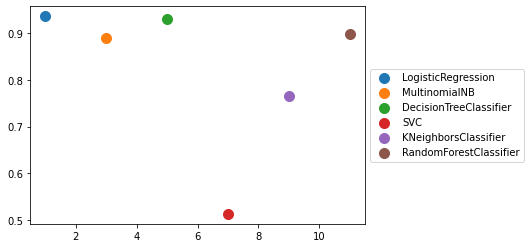

In [33]:
# Initialize dict to save acc for each classifier
true_accs = dict()

# Compute accuracy for each classifier using true labels and save result
for clf in clfs:
    acc = calculate_accuracy(X_train, y_train, clf=clf)
    true_accs[f"{clf_name(clf)}"] = acc

    
# Plot results
plot_accuracies(true_accs)

Some classifiers outperform the original choice (Multinomial Naive Bayes).
So, it is worth trying these other classifiers in conjunction with the automatic labeling:

100%|██████████| 1564/1564 [00:00<00:00, 2421.84it/s]


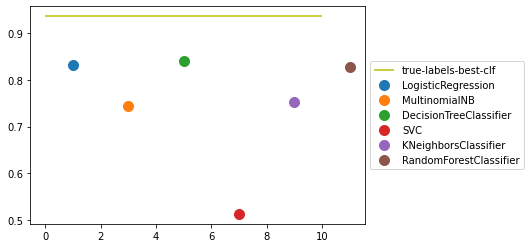

In [34]:
# Initialize dict to save acc for each classifier
clf_accs = dict()

# Save accuracy of best classifier with true labels
clf_accs['true-labels-best-clf'] = max(true_accs.values())

# Perform automatic labeling for each classifier
for clf in clfs:
    *_, acc = label_given_rules(X_train, 
                                lfs, 
                                clf, 
                                f"{clf_name(clf)}", 
                                accs_dict=clf_accs, 
                                verbose=False)
    
plot_accuracies(clf_accs)

There is still some road ahead if you want to hit the upper bound. However, notice that some of the new classifiers reach accuracies around 85%. This means that by changing classifiers we can get an extra 10% increase using our automatic labeling technique!

Let's reflect on what you have done in this lab:
1. You defined an automated labeling process for your data (isn't that cool?)
2. You tested different classifiers.
3. The accuracy is currently at 85%! Good job!


### Bonus Section - Variance in small data datasets

Snorkel's official tutorial uses this same dataset and their strategy achieves close to 94% classification accuracy. You might be wondering how did they achieve such a high accuracy score? 

It turns out that this is a small dataset and how you split the data for training and testing plays a big role when analyzing performance metrics. More concretely, in Snorkel's tutorial the testing data set consisted of comments from video #5, whereas the rest of the comments made the training set. This is very different of what you have done in this ungraded lab.  

In this bonus section, you will characterize how different data splits affect accuracy by measuring its variability. The strategy will be comparing the accuracies when using the comments of one video for testing and the rest for training. You can think of this as a "leave one video out" procedure. Then you will compute statistics over all runs.

Let's get started by properly splitting the data:

In [35]:
# Create a train/test split depending on number of video
def get_split(video_num):
    X_train_new = df_labeled[df_labeled.video != video_num]
    X_test_new = df_labeled[df_labeled.video == video_num]
    y_train_new = df_labeled[df_labeled.video != video_num].label
    y_test_new = df_labeled[df_labeled.video == video_num].label
    
    return X_train_new, y_train_new, X_test_new, y_test_new

# Save every split on a list
splits = []
for i in range(1, 6):
    splits.append((get_split(i)))

### Variance with true labels

Let's first check how variable the accuracy is when training different models with the true labels. You should expect the true labels will yield a lower variability, so let's use them as a baseline to compare:

In [36]:
# Initialize dict to save results to (var stands for variance)
true_accs_var = dict()

# Compute acc for every classifier and split
for clf in clfs:
    true_accs_var[f"{clf_name(clf)}"] = []
    for i, split in enumerate(splits):
        acc = calculate_accuracy(split[0], split[1], X_te=split[2], y_te=split[3], clf=clf)
        true_accs_var[f"{clf_name(clf)}"].append(acc)

In [37]:
true_accs_var_df = pd.DataFrame.from_dict(true_accs_var)
true_accs_var_df

,LogisticRegression,MultinomialNB,DecisionTreeClassifier,SVC,KNeighborsClassifier,RandomForestClassifier
0,0.920000,0.802857,0.865714,0.500000,0.642857,0.920000
1,0.945714,0.877143,0.937143,0.500000,0.634286,0.908571
2,0.926941,0.876712,0.968037,0.538813,0.824201,0.913242
3,0.955357,0.881696,0.962054,0.546875,0.756696,0.933036
4,0.910811,0.897297,0.900000,0.470270,0.764865,0.894595


It is hard to have a sense of the distribution by just looking at a table.

Let's look at the scatterplot to get a better sense of how much variance there is across splits. 

Notice that this exercise is not an in-depth analysis, just a high level overview of what happens when dealing with small data.

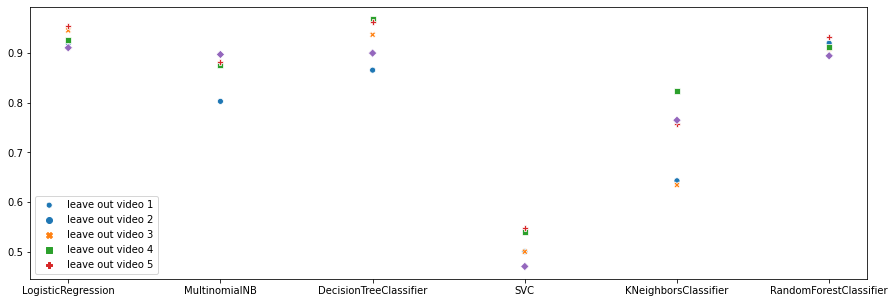

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=true_accs_var_df.T, ax=ax)
ax.legend(loc="best", labels=["leave out video 1", "leave out video 2", "leave out video 3","leave out video 4", "leave out video 5"])
plt.show()

There is definitely some variability across splits. The effect is more noticeable for the `kNN` algorithm. But in general, variability is not very extreme.  

If you want to check the actual values of the descriptive statistics you can do so by using the `describe` method of the dataframe, like this:

```python
true_accs_var_df.describe()
```

### Variance with automatic labels

The rules defined for the automatic labeling process are noisy. Therefore,  you can expect that the model accuracy will reflect some of that labeling noise . Let's check the statistics with automated labeling:

In [39]:
# Initialize dict to save results to (var stands for variance)
clf_accs_var = dict()

# Compute acc for every classifier and split
for clf in clfs:
    clf_accs_var[f"{clf_name(clf)}"] = []
    for i, split in enumerate(splits):
        *_, acc = label_given_rules(split[0], 
                                    lfs, 
                                    clf, 
                                    f"{clf_name(clf)}"+"-split-"+str(i), 
                                    X_te=split[2], 
                                    y_te=split[3], 
                                    verbose=False)
        
        clf_accs_var[f"{clf_name(clf)}"].append(acc)

100%|██████████| 1586/1586 [00:00<00:00, 2451.51it/s]


In [40]:
clf_accs_var_df = pd.DataFrame.from_dict(clf_accs_var)
clf_accs_var_df

,LogisticRegression,MultinomialNB,DecisionTreeClassifier,SVC,KNeighborsClassifier,RandomForestClassifier
0,0.780000,0.591429,0.760000,0.500000,0.640000,0.751429
1,0.705714,0.622857,0.720000,0.500000,0.625714,0.697143
2,0.885845,0.831050,0.899543,0.461187,0.824201,0.897260
3,0.917411,0.868304,0.921875,0.453125,0.754464,0.919643
4,0.886486,0.832432,0.851351,0.470270,0.754054,0.878378


Again let's make a scatterplot as it is hard to get a sense of the distribution across splits just form the table:

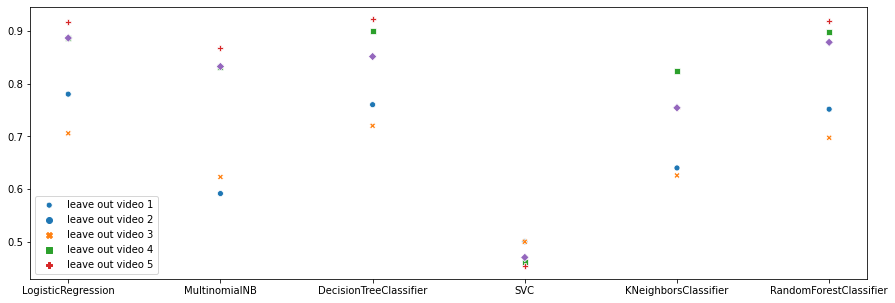

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=clf_accs_var_df.T, ax=ax)
ax.legend(loc="best", labels=["leave out video 1", "leave out video 2", "leave out video 3","leave out video 4", "leave out video 5"])
plt.show()

Accuracies have a greater variance when calculated alongside the automatic labeling. This is expected as this very process introduces some noise to the data when compared with using the true labels. 

Stratification allows you to control for proper class balance, as you did before in this lab. However, you cannot control the patterns in the comments (for which you built some rules for) that end up in the training and test split. This might dampen the classification process. More concretely, Snorkel can give a lot of importance to a rule that does a good job at classifying spam for a given pattern, but due to how the data is split, this pattern could be mostly absent in the test set. This is something to take into account when working with small data. 

For this particular data set, it looks like  `Logistic Regression`, `Decision Trees` or `Random Forest`, are the best classifiers as they yield the highest accuracy with low intersplit variability. To check the actual values don't forget you can use the `describe` method as mentioned earlier.

**Congratulations on finishing this ungraded lab!** Now you should feel more familiar with the use of Snorkel and have a better understanding of the importance of data labeling. This process is of uttermost importance to guarantee the success of your Machine Learning models.

**Keep it up!**